[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scienception/AML1/blob/master/ExamProject_Boston.ipynb)


# Applied Machine Learning 1 Project
## Predicting Boston Housing Prices
#### Maria Caterina Cevallos Brenes

# Table of Contents

* [Abstract](#abstract)
* [Library requirements](#library)
* [Data preprocessing](#preprocess)
    * [Loading](#load)
    * [Handling missing and duplicated data](#clean1)
    * [Exploratory data analysis ( 𝐸𝐷𝐴 )](#eda)
    * [Outliers identification and removal](#clean2)
    * [Transforming the data](#transform)
        * [Log transformation](#log)
        * [Scaling](#scale)    
* [Feature Selection](#feature_selection)
    * [Correlation Matrix](#correlation)
    * [Feature selection methods](#feature_methods)
        * [Filter method, Univariate feature selection](#univariate)
        * [Wrapper method, Recursive Feature Selection](#recursive)
        * [Ensemble method](#ensemble)
        * [Common selected features](#common)
* [Model Selection](#model_selection)
    * [Splitting training and test sets](#split)
    * [GridSearch + Cross validation](#gridsearchcv)
* [Testing best-performing model](#testing)
* [Testing alternative pipelines](#alternative)
* [Conclusions](#conclusions)

# Abstract <a class="anchor" id="abstract"></a>

The forecast of housing prices is an important part of good decision-making in real-state investment both for buyers and sellers. In an attempt of making such prediction possible for the particular case of Boston housing market we seek at: 

* Examining the impact of the attributes influencing the monetary value of properties
* Discovering the most suitable explanatory variables
* Training several models based on the most relevant features 
* Assesing the predictive power of the models
* Selecting the model with best overall performance 

The Boston Project dataset was created in 1978 by Harrison and Rubinfeld to study the effects of air pollution on housing prices, and has become a wellknown dataset in the data analysis community. Retrieved from the UCI Machine Learning Repository, it consists of 506 observations of 14 attributes: 13 input variables covering many aspects of residential houses and the outcome variable MEDV (median value of house price in thousands).

Below is the full list of the attributes (the features + target variable) and a brief description of each.

|| attribute| description|
|-| :---|:--- |
|1| CRIM| per capita crime rate by town|
|2| ZN| proportion of residential land zoned for lots over 25,000 sq.ft|
|3| INDUS| proportion of non-retail business acres per town|
|4| CHAS| Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)|
|5| NOX| nitric oxides concentration (parts per 10 million)|
|6| RM| average number of rooms per dwelling|
|7| AGE| proportion of owner-occupied units built prior to 1940|
|8| DIS| weighted distances to five Boston employment centers|
|9| RAD| index of accessibility to radial highways|
|10| TAX| full-value property-tax rate per 10,000 dollars|
|11| PTRATIO| pupil-teacher ratio by town|
|12| B| 1000(Bk − 0.63)2 where Bk is the proportion of blacks by town|
|13| LSTAT| percentage lower status of the population|
|14| MEDV| Median value of owner-occupied homes in thousands of dollars|

The goal of the project is therefore, to create a regression model that, given the features, is able to accurately estimate the price of a given house.

# Library requirements <a class="anchor" id="library"></a>

In [8]:
# !pip3 install ptitprince
# !pip3 install matplotlib-venn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import ptitprince as pt
import itertools
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor

%matplotlib inline

# 1. Data preprocessing <a class="anchor" id="preprocess"></a>

### 1.1 Loading <a class="anchor" id="load"></a>

In [9]:
# loading the data
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston = pd.read_csv("./housing.csv", delim_whitespace=True, names = cols)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [10]:
# dimension of the dataset
boston.shape

(506, 14)

### 1.2 Data cleansing part 1: handling missing and duplicated data <a class="anchor" id="clean1"></a>

In [11]:
# making sure there aren't any missing values
boston.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [12]:
# looking for duplicate samples
boston.duplicated().sum()

0

### 1.3 Exploratory data analysis ($EDA$) <a class="anchor" id="eda"></a>

In this section we perform a preliminary exploration of each of the features concerning the 506 neighborhoods in Boston via descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution.

In [13]:
boston.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.61,8.60,0.01,0.08,0.26,3.68,88.98
ZN,506.0,11.36,23.32,0.00,0.00,0.00,12.50,100.00
INDUS,506.0,11.14,6.86,0.46,5.19,9.69,18.10,27.74
CHAS,506.0,0.07,0.25,0.00,0.00,0.00,0.00,1.00
NOX,506.0,0.55,0.12,0.38,0.45,0.54,0.62,0.87
RM,506.0,6.28,0.70,3.56,5.89,6.21,6.62,8.78
AGE,506.0,68.57,28.15,2.90,45.02,77.50,94.07,100.00
DIS,506.0,3.80,2.11,1.13,2.10,3.21,5.19,12.13
RAD,506.0,9.55,8.71,1.00,4.00,5.00,24.00,24.00
TAX,506.0,408.24,168.54,187.00,279.00,330.00,666.00,711.00


Two rows in particular show interesting properties: 
* ZN (proportion of residential land zoned for lots over 25,000 sq.ft.) with 0 for 25th, 50th percentiles
* CHAS (Charles River dummy variable: 1 if tract bounds river, 0 otherwise) with 0 for 25th, 50th and 75th percentiles

This is understandable as both are conditional variables. 

To visualize the above metrics in order to convey maximal statistical information while preserving the desired ‘inference at a glance’ we use [raincloud plots](https://peerj.com/preprints/27137.pdf) from [PtitPrince library](https://github.com/pog87/PtitPrince). These “raincloud plots” can depict raw data, probability density, and key summary statistics such as median, interquartile range and outliers.

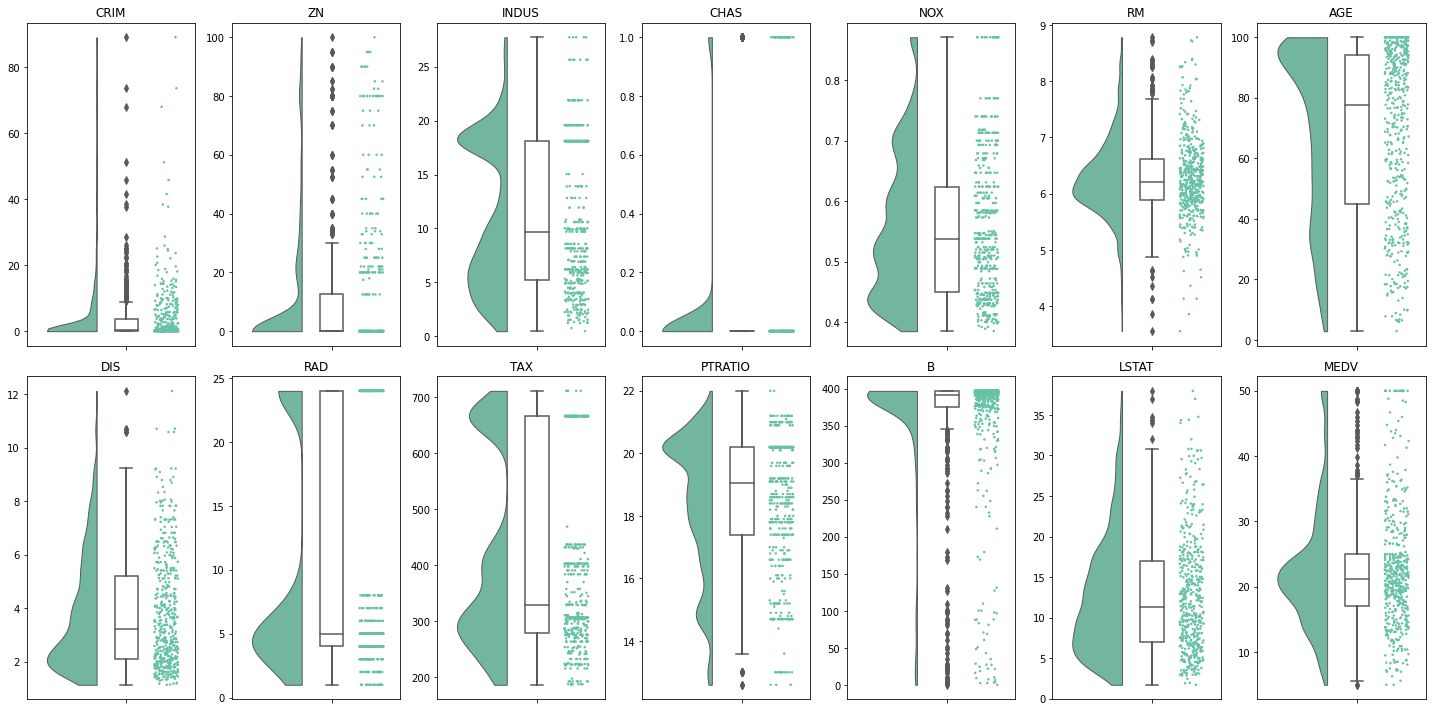

In [14]:
# create a figure and a set of subplots.
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(20, 10))
# to iterate easily use .flatten(): no need for nested loops to deal with a variable # of rows and cols in figure
axs = axs.flatten()
index=0

for col_name in boston.columns: 
    ax=axs[index]
    pt.RainCloud(
                y=col_name, 
                data=boston, 
                ax=ax,
                width_viol=.5,
                width_box=.12,
                point_size = 2.5,
                offset=.15,
                move=.2,
                jitter=0.06,
    )
    ax.set_title(col_name)
    ax.set(ylabel=None)   
    index+=1
plt.tight_layout()


From these plots we can observe that CHAS and RAD take discrete values, as expected, given that they correspond to nominal categorical and ordinal categorical variables respectively. 

In [15]:
print("CHAS:")
print("val counts")
print(boston['CHAS'].value_counts())
print("\n")
print("RAD:")
print("val counts")
print(boston['RAD'].value_counts())

CHAS:
val counts
0    471
1     35
Name: CHAS, dtype: int64


RAD:
val counts
24    132
5     115
4     110
3      38
6      26
2      24
8      24
1      20
7      17
Name: RAD, dtype: int64


The rainbow plot also shows that features CRIM, ZN, B have highly skewed distributions; INDUS and TAX, binomial distributions; LSTAT and DIS, a sort of Gumbel distribution and RM and MEDV, normal distributions. 

### 1.4 Data cleansing part 2: Outliers identification and removal <a class="anchor" id="clean2"></a>

CRIM, ZN, RM and B present several outliers. We computer their percentage as follows:

In [16]:
pd.set_option('display.precision', 2)

Q1 = boston.quantile(0.25) # splits off the lowest 25% of data from the highest 75% (=median of the lower half)
Q3 = boston.quantile(0.75) # splits off the highest 25% of data from the lowest 75% (=median of the upper half)
IQR = Q3 - Q1              # range of the middle half of the data set

# how many samples contain outliers? any = True?, axis=1 sum across all columns (features)
outliers = ((boston < (Q1 - 1.5 * IQR)) | (boston > (Q3 + 1.5 * IQR))).any(axis=1).sum()
print("Number of samples containing outliers:", outliers, "\n")

# percentage of outliers per feature? axis=0 sum across all samples
outliers_per_feature_pct = ((boston < (Q1 - 1.5 * IQR)) | (boston > (Q3 + 1.5 * IQR))).sum(axis=0)/boston.count()*100
print("Percentage of outliers per feature:")

for index, value in outliers_per_feature_pct.sort_values(ascending=False).items():
    print ("%s:"% index," "*(7-len(index)),"%.2f%%" %value)

Number of samples containing outliers: 238 

Percentage of outliers per feature:
B:        15.22%
ZN:       13.44%
CRIM:     13.04%
MEDV:     7.91%
CHAS:     6.92%
RM:       5.93%
PTRATIO:  2.96%
LSTAT:    1.38%
DIS:      0.99%
INDUS:    0.00%
NOX:      0.00%
AGE:      0.00%
RAD:      0.00%
TAX:      0.00%


Now let's consider only extreme outliers (those below the 1st and above the 99th percentiles). 

In [17]:
extreme_outliers = ((boston < boston.quantile(0.01)) | (boston > boston.quantile(0.99))).any(axis=1).sum()
print("Number of samples containing 'extreme' outliers:", extreme_outliers)

Number of samples containing 'extreme' outliers: 76


Since the number of samples containing extreme feature values is considerable, trimming/truncation would not be the most suitable way of handling outliers. Instead of simply discarding these data points we will replace them with the 1st and 99th percentile. This procedure, known as "winsorizing" maintains the data set size.

A winsorized mean would not the same as a truncated mean. For instance, the 2% trimmed mean is the average of the 1st to 99th percentile of the data, while the 98% winsorized mean sets the bottom 1% to the 1st percentile, the top 1% to the 99th percentile, and then averages the data.

In [18]:
boston_winsorized = pd.DataFrame(index=boston.index,columns=cols) # initialize empty dataframe

for col in cols: 
     boston_winsorized[col] = stats.mstats.winsorize(boston[col], limits=0.01)

df1 = boston.describe().T.round(2)
df2 = boston_winsorized.describe().T.round(2)
df_combined = pd.concat([df1,df2],axis=1,keys=['raw','winsorized']).swaplevel(0,1,axis=1).sort_index(axis=1, level=0)

In [19]:
pd.options.display.float_format = "{:,.2f}".format

def highlight_cols(s):
    # input: s is a pd.Series with an attribute name
    #        s.name --> ('25%', 'raw')
    #                   ('25%', 'winsorized')
    #                    ...
    # 1) Take the parent level of s.name (first value of the tuple) E.g. 25%
    # 2) Select the subset from df, given step 1
    # --> this will give you the df:  25% - raw |  25% - winsorized back
    # 3) check if the amount of unique values (for each row) > 1
    #    If so: return a red text
    #    if not: return an empty string
    # Output: a list with the desired style for serie x

    return ['color: red' if x else '' for x in df_combined[s.name[0]].nunique(axis=1) > 1]

df_combined.style.apply(highlight_cols).format(precision=2)

From the table above it can be observed that max, min, mean and std values were slightly modified. Quartiles and counts remained unchanged. The outcome of this procedure is depicted in the box plots below.

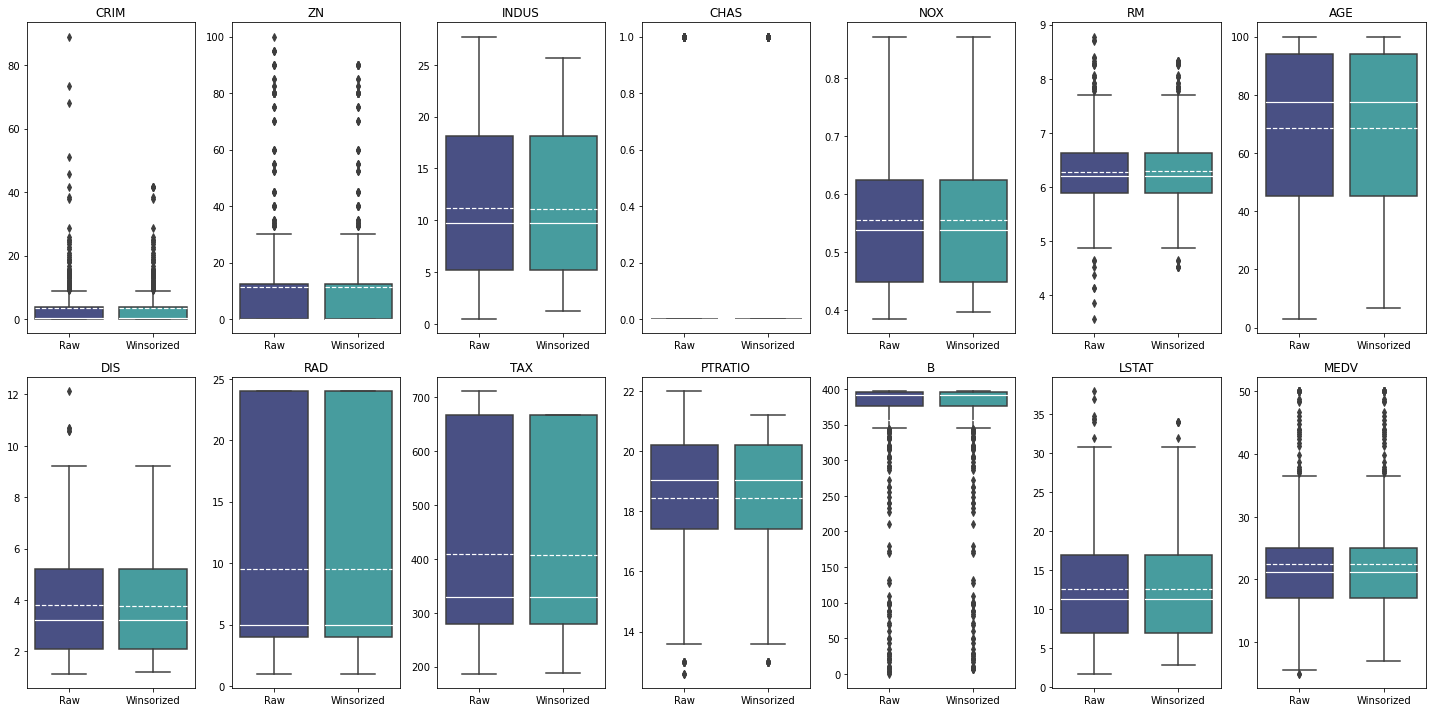

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(20, 10))
# to iterate easily use .flatten(): no need for nested loops to deal with a variable # of rows and cols in figure
axs = axs.flatten()
index=0
meanlineprops = dict(linestyle='--', linewidth=1.2, color='white')
medianlineprops = dict(linestyle='-', linewidth=1.2, color='white')

for col_name in boston.columns: 
    combined_dfs = pd.DataFrame({'Raw': boston[col_name],
                                 'Winsorized': boston_winsorized[col_name]})
    sns.boxplot(
                data=combined_dfs, 
                ax=axs[index],
                medianprops=medianlineprops,
                meanprops=meanlineprops,
                meanline=True,
                showmeans=True,
                palette='mako'
    )
    axs[index].set_title(col_name)
    axs[index].set(ylabel=None)    
    index+=1
plt.tight_layout()

### 1.5 Transforming the data <a class="anchor" id="transform"></a>

Removing the skeweness of the features and scaling them to a certain range.

#### 1.5.1 Log transformation of skewed distribution <a class="anchor" id="log"></a>

As it can be observed from the rainbow plots, the right-skewed distribution of variables CRIM, ZN and DIS and the left-skewed distribution of B suggests that a log transformation would be appropriate. 

Since these transformations don't compute any statistics, we are allowed to apply them to the whole dataset (otherwise it could potentially introduce a bias and artificially increase the testing set performance). 

In [21]:
index=0
boston_scaled = pd.DataFrame(index=boston.index,columns=cols)
logged_features = []

for feature, series in boston_winsorized.items(): # items: key=col_name, values=series
    # if the distribution is highly right-skewed (usually greater than 1) and it isn't categorical variable (CHAS, RAD) nor the target
    if series.skew() > 0.8 and feature not in ('CHAS','RAD','MEDV'):
        boston_scaled[feature] = np.log(series+1) 
        logged_features.append(feature)
    # if the distribution is highly left-skewed (usually less than 1) and it isn't categorical variable (CHAS, RAD) nor the target
    elif series.skew() < -0.8 and feature not in ('CHAS','RAD','MEDV'):
        boston_scaled[feature] = np.log((max(series+1) - series))
        logged_features.append(feature)
    else:
        boston_scaled[feature] = series
    index+=1
    
print(logged_features)

['CRIM', 'ZN', 'DIS', 'B', 'LSTAT']


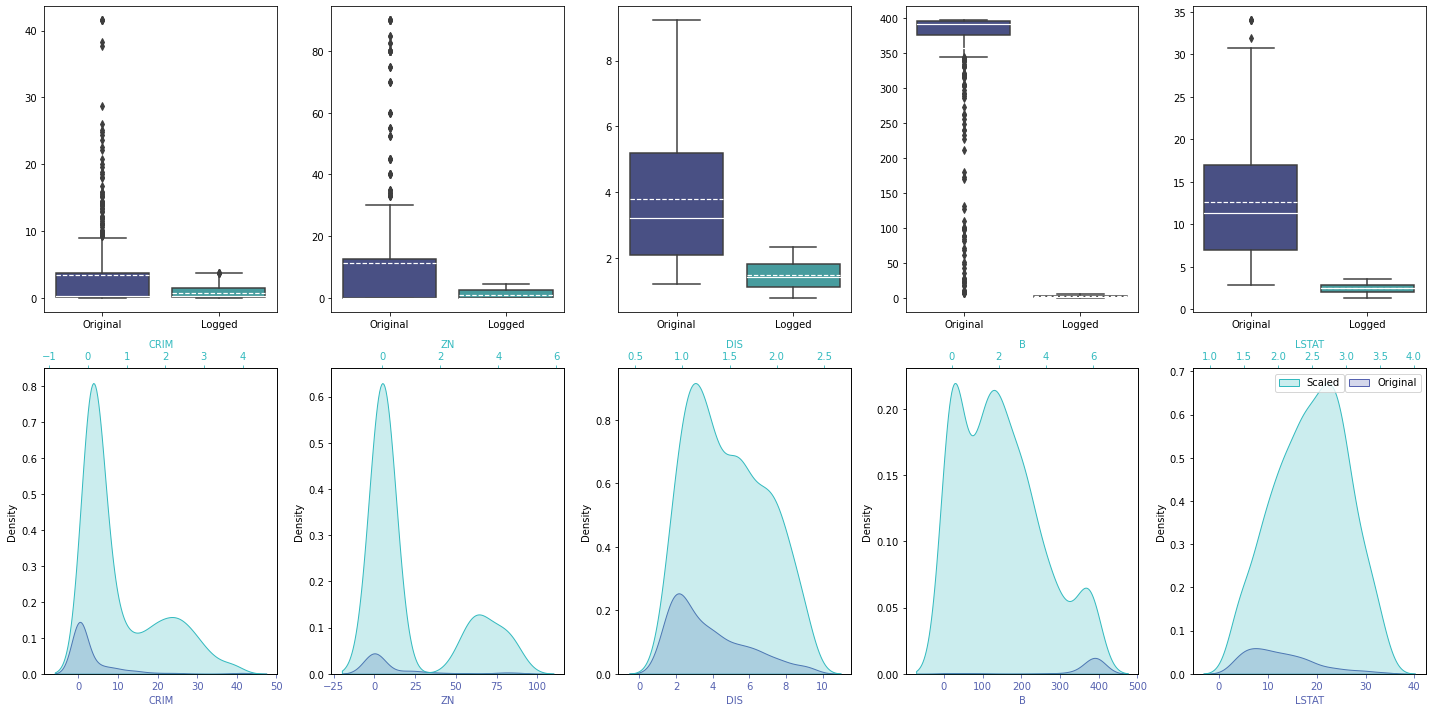

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axs = axs.flatten()
index=0
meanlineprops = dict(linestyle='--', linewidth=1.2, color='white')
medianlineprops = dict(linestyle='-', linewidth=1.2, color='white')

for feature in logged_features: 
    combined_dfs = pd.DataFrame({'Original': boston_winsorized[feature],
                                 'Logged': boston_scaled[feature]})
    sns.boxplot(
                data=combined_dfs, 
                ax=axs[index],
                medianprops=medianlineprops,
                meanprops=meanlineprops,
                meanline=True,
                showmeans=True,
                palette='mako'
    )
    index+=1
    
for feature in logged_features: 
    ax1 = axs[index]
    ax1.xaxis.label.set_color('#5662B0')
    ax1.tick_params(axis='x', colors='#5662B0')
    ax2 = ax1.twiny()
    ax2.xaxis.label.set_color('#33BABF')
    ax2.tick_params(axis='x', colors='#33BABF')
    sns.kdeplot(
                boston_winsorized[feature], 
                ax=ax1,
                color='#5662B0',
                fill=True,
                label="Original"
    )
    sns.kdeplot(
                boston_scaled[feature], 
                ax=ax2,
                color='#33BABF',
                fill=True,
                label="Scaled"
    )
    index+=1

plt.tight_layout()
ax1.legend()
ax2.legend(loc='upper center')

#### 1.5.2 Scaling  <a class="anchor" id="scale"></a>

Scaling refers to bringing down the values of all the independent features of our dataset on the same scale. 
This data transformation makes it easier for algorithms to tease apart meaningful relationships between variables.

This is due to the fact that most machine learning algorithms use Euclidean distance (between data points) in their computations. Without scaling, higher values would be given higher weightage and lower values, lower weightage, meaning that if one of the features has a broad range of values, the distance will be governed by this particular feature. 

Therefore, the range of all features should be normalized in an effort to make each feature contribute approximately proportionately to the final distance.

Another reason why feature scaling is typically adopted is to reduce computational time. Gradient descent converges much faster with feature scaling than without it.

Since this transformation requires fitting some parameters to the data we should split at this stage the training set from the test set. The fit should be applied only to the training set (since it derives statistics from it, in this case, the minimum and maximum values) while the transform method should be used on both (training and test) as the same preprocessing should be applied to all the data. This is achieved by using `fit_transform` on the training set and only `transform` on the test set. The goal here is to rescale the data without incurring in "data leakage".

Nonetheless, because a cross-validation procedure will be performed and the validation fold shouldn't be fitted either, we will utilize a Pipeline that will handle `fit_transform` and `transform` automatically. 

For visualization purposes though, we will re-scale the whole data set to get a feeling of how the overlap between the distribution of the features would look like.

In [23]:
array = boston_scaled.values
# separate array into input (features) and output (labels) components
X = array[:,0:13]
y = array[:,13]

scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler.fit_transform(X)

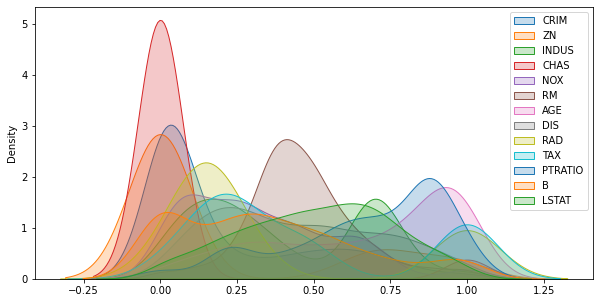

In [24]:
plt.figure(figsize=(10,5))
for index, col in enumerate(cols[:-1]):
    sns.kdeplot(x=X_scaled.T[index], shade=True, label=col)
plt.legend()

# 2. Feature Selection <a class="anchor" id="feature_selection"></a>

### 2.1 Correlation Matrix <a class="anchor" id="correlation"></a>

We select those features which contribute the most to the prediction variable. Having irrelevant features in our data can decrease the accuracy of the model and make such model learn based on irrelevant features. The less redundant the data, the less opportunities to make decisions based on noise. 

In general the objective of feature selection is:

1. Reduction of Overfitting
2. Improvement of Accuracy
3. Reduction of Training Time

Here we compute the pairwise correlation between the features. The correlation matrix measures the linear relationships between the variables. Each correlation coefficient ranges from -1 to 1. If the value is close to 1, it implies a strong positive correlation between the variables. When it is close to -1, the variables possess a strong negative correlation.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.41,0.67,-0.02,0.71,-0.29,0.56,-0.66,0.91,0.87,0.39,0.40,0.57,-0.46
ZN,-0.41,1.00,-0.59,-0.04,-0.55,0.34,-0.58,0.65,-0.35,-0.39,-0.46,-0.20,-0.49,0.38
INDUS,0.67,-0.59,1.00,0.06,0.77,-0.40,0.65,-0.76,0.60,0.72,0.39,0.35,0.61,-0.48
CHAS,-0.02,-0.04,0.06,1.00,0.09,0.09,0.09,-0.09,-0.01,-0.04,-0.12,0.02,-0.07,0.18
NOX,0.71,-0.55,0.77,0.09,1.00,-0.31,0.73,-0.83,0.61,0.67,0.19,0.36,0.59,-0.43
RM,-0.29,0.34,-0.40,0.09,-0.31,1.00,-0.24,0.25,-0.21,-0.29,-0.36,-0.09,-0.67,0.71
AGE,0.56,-0.58,0.65,0.09,0.73,-0.24,1.00,-0.78,0.46,0.51,0.26,0.26,0.62,-0.38
DIS,-0.66,0.65,-0.76,-0.09,-0.83,0.25,-0.78,1.00,-0.55,-0.61,-0.25,-0.29,-0.53,0.29
RAD,0.91,-0.35,0.60,-0.01,0.61,-0.21,0.46,-0.55,1.00,0.92,0.47,0.35,0.47,-0.38
TAX,0.87,-0.39,0.72,-0.04,0.67,-0.29,0.51,-0.61,0.92,1.00,0.46,0.38,0.53,-0.47


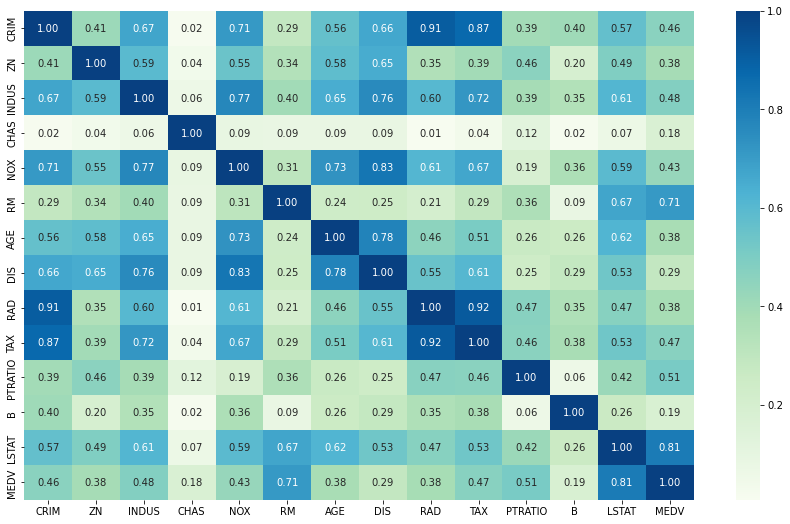

In [25]:
var_corr = boston_scaled.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(var_corr.abs(), cmap="GnBu",annot=True,fmt=".2f",linewidths=0,ax=ax)
var_corr

When selecting features for a linear regression model it is crucial to check for multi-colinearity. The features pairs  betwen RAD, TAX and CRIM are strongly correlated. We won't select them together for training the model. 

In [26]:
boston_scaled.drop(['CRIM', 'RAD'], inplace=True, axis=1)

Regarding the correlation to target variable MEDV, we can see that the number of rooms (RM) has the strongest positive correlation while the percentage of lower status of the population (LSTAT) has the strongest negative correlation. The features with the least correlation to MEDV are proximity Charles River (CHAS) and proportion of black people in town (B).

In [27]:
var_corr[var_corr['MEDV'].abs()>0.5]['MEDV']

RM         0.71
PTRATIO   -0.51
LSTAT     -0.81
MEDV       1.00
Name: MEDV, dtype: float64

### 2.2 Feature selection methods <a class="anchor" id="feature_methods"></a>

#### 2.2.1  Filter method, Univariate feature selection <a class="anchor" id="univariate"></a>

Univariate feature selection works by selecting the best features based on univariate statistical tests. It simply computes the variance of each feature, and then keeps the the top k features with the largest variance.

It is assumed that features with a higher variance may contain more useful information, but they do not consider the relationship between feature variables or feature and target variables, which is one of the drawbacks of filter methods.

In [28]:
# Create and fit selector
X_df = boston_scaled.loc[:, boston_scaled.columns != "MEDV"]
y_df = boston_scaled["MEDV"]
selector = SelectKBest(f_regression, k=7)
fit = selector.fit(X_df, y_df)

# Get columns to keep 
cols1 = fit.get_support(indices=True) # gets a mask (col numbers) of the selected features
set1 = set(boston_scaled.columns[cols1])
set1

{'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM', 'TAX', 'ZN'}

#### 2.2.2  Wrapper method, Recursive Feature Selection <a class="anchor" id="recursive"></a>

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination, or RFE for short, is a greedy search algorithm that attempts to find the “optimal” feature subset by iteratively selecting features based on the estimator performance. 

First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [29]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=7)
fit = rfe.fit(X_df, y_df)
# Get columns to keep and create new dataframe with those only
cols2 = np.where(fit.support_== True)
set2 = set(boston_scaled.columns[cols2])
set2

{'CHAS', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM'}

Before moving forward we will use RFECV to make sure that keeping 7 features is a good threshold. 

Optimal number of features : 6


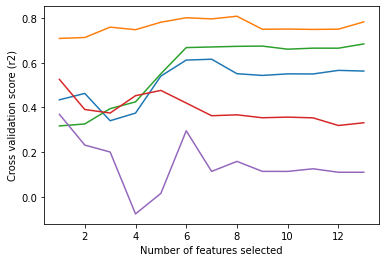

{'CHAS', 'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM'}

In [30]:
# Create the RFE object and compute a cross-validated score.
model = LinearRegression()
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select=1
rfecv = RFECV(
    estimator=model,
    step=1,
    scoring="r2",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

sub_cv_results_={key: value for key, value in rfecv.cv_results_.items() if "split" in key}
keys, values = np.array(list(sub_cv_results_.items()), dtype=object).T
values_zipped = list(zip(*values))

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")

plt.plot(
    range(min_features_to_select, len(values_zipped) + min_features_to_select),
    values_zipped,
)
plt.show()

cols_cv = np.where(rfecv.ranking_== 1)
set_cv = set(boston_scaled.columns[cols2])
set_cv

It seems that after 6 features the performance stabilizes or reaches a plateau. For this reason we will search the most relevant 6 features during cross-validation within the Pipeline.

#### 2.2.3  Ensemble method <a class="anchor" id="ensemble"></a>

Methods that use ensembles of decision trees (like Random Forest or Extra Trees Regressor) can compute the relative importance of each attribute. We will use these importance values for the feature selection process.

In [31]:
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_df, y_df)
list2 = sorted(list(enumerate(model.feature_importances_)), key=lambda x:x[1])
cols3 = list(np.array(list2).T[0].astype(int))[-7:]
set3 = set(boston_scaled.columns[cols3])
set3

{'DIS', 'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM', 'TAX'}

### 2.2.4 Common selected features <a class="anchor" id="common"></a>

/usr/local/anaconda3/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


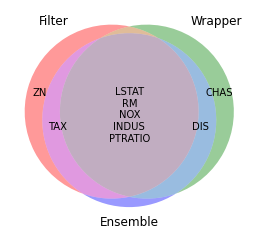

In [32]:
venn=venn3([set1, set2, set3], ('Filter', 'Wrapper', 'Ensemble'))
venn.get_label_by_id('100').set_text('\n'.join(set1-set2-set3))
venn.get_label_by_id('110').set_text('\n'.join(set1&set2-set3))
venn.get_label_by_id('010').set_text('\n'.join(set2-set3-set1))
venn.get_label_by_id('101').set_text('\n'.join(set1&set3-set2))
venn.get_label_by_id('111').set_text('\n'.join(set1&set2&set3))
venn.get_label_by_id('011').set_text('\n'.join(set2&set3-set1))
venn.get_label_by_id('001').set_text('\n'.join(set3-set2-set1))
plt.show()

In [33]:
common_set = set1.intersection(set2).intersection(set3)
common_set

{'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM'}

In [34]:
#and create new dataframe with common only and including target
common_set.add('MEDV')
common_cols = list(common_set)
boston_common = boston_scaled[common_cols]

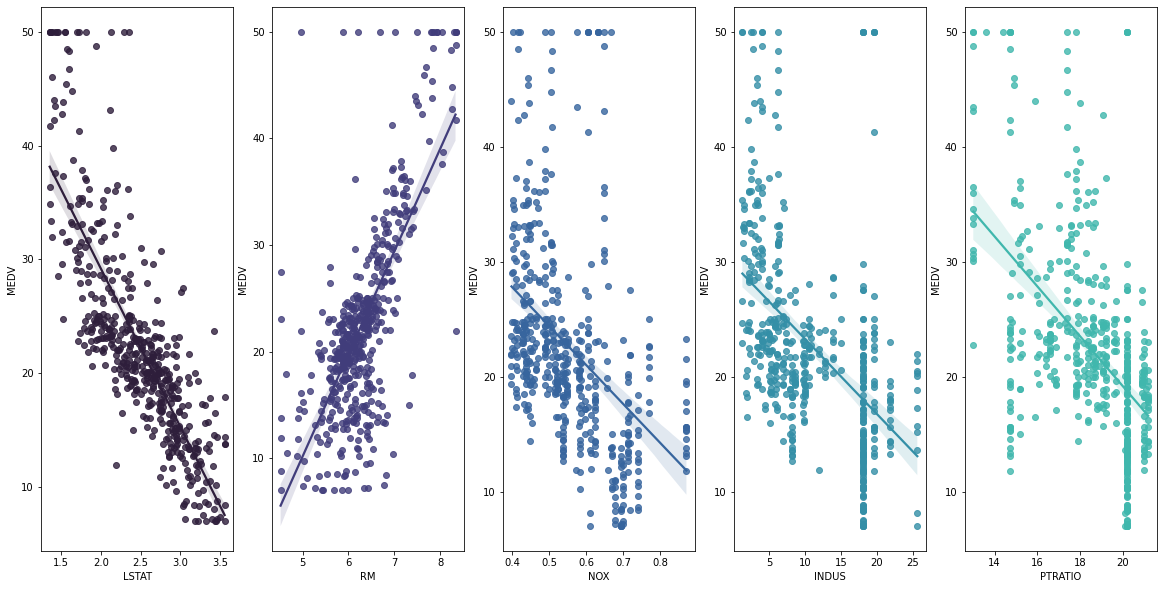

In [35]:
boston_common_x=boston_common.loc[:, boston_common.columns != "MEDV"]

n_features = len(boston_common_x.columns)

fig, axs = plt.subplots(nrows=1, ncols=n_features, figsize=(20, 10))
axs = axs.flatten()
index=0
palette = itertools.cycle(sns.color_palette("mako"))

for col_name, series in boston_common_x.items(): 
    sns.regplot(y=boston_common["MEDV"], x=series, ax=axs[index], color=next(palette))
    ax=axs[index]
    index+=1

If we compare the common features obtained in this section with the ones obtained when computing the correlation matrix we can conclude that the features 'RM', 'PTRATIO' and 'LSTAT' are apparently essential and may be the most appropriate for using as predictors.

Let's now retrieve which are the best 3 features computed by SelectKBest:

In [36]:
selector = SelectKBest(f_regression, k=3)
fit = selector.fit(X_df, y_df)
cols_final = fit.get_support(indices=True) 
set(boston_scaled.columns[cols_final])

{'LSTAT', 'PTRATIO', 'RM'}

Since they seem to be the exactly the "good predictors" mentioned above, we will therefore use SelectKBest with k=7 in our pipeline and apply it only to the training set to avoid data leakage. Although unlikely, these features may change but by performing feature selection after splitting it will not induce overfitting.

# 3. Model Selection   <a class="anchor" id="model_selection"></a>

## 3.1 Splitting training and test sets   <a class="anchor" id="split"></a>

Now we split the Boston dataset into training and testing subsets. The data is also shuffled randomly to remove any bias in the ordering of the dataset.

We partition the data on a 8/2 ratio as training/test datasets.

In [30]:
array = boston_scaled.values
num_features = boston_scaled.shape[1]-1

# separate array into input (features) and output (labels) components
X = array[:,0:num_features]
y = array[:,num_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3.2 Cross-validation, hyperparameter tuning and training (GridsearchCV --refit=True)  <a class="anchor" id="gridsearchcv"></a>

The purpose of creating the following pipeline is to try multiple alternatives in the same setting, to see which methods best apply to the domain at hand.

The grid search technique is a systematic way of going through different combinations of hyperparameter values while cross validating the results to determine the combination giving the best performance based on a scoring function. 

We can apply `GridSearchCV` by specifying a grid of values. `GridSearchCV` will return the best hyperparameter values for our model, after fitting the supplied data. This parameter sweep functionality substitutes a less efficient guess-work procedure.

When performing cross-validation the dataset is split into k "folds" of equal size, each fold acting as the testing set 1 time, and acting as part of the training set k-1 times. The scores for the k learning experiments are then averaged out.


<img src="CV.png" alt="drawing" width="450"/>

If we didn't use a cross-validation the estimate of out-of-sample performance would have a high variance and the risk that grid search would select hyper-parameter value combinations that perform very well on a specific train-test split but poorly otherwise would be higher.

In this section we perform Grid Search with k-fold cross-validation, using a Pipeline. Grid Search will automatically choose the best features and fit MinMaxScaller on the k-1 folds (not the entire training set). 

Every time fit is called, `Pipeline` will automatically choose the n best features fit and transform the training k-1 folds and call transform on the k validation fold (temporary unseen test set) using fitted `MinMaxScaler`.

Finally, because we use `refit=True`, `GridSearchCV` will use the entire training set with best found hyperparameters to train a final model. The final pipeline fitted on the entire training set will be available in the attribute `best_estimator_`. This enables simply calling `cv.predict(X_test)` or `cv.score(X_test, y_test)` (i.e directly on fitted GridSearchCV object) without worrying about preprocessing the test set or anything else. 

<img src="gridsearchcv.png" alt="drawing" width="450"/>
  
If we performed feature selection and scaling before splitting into training/test set the variance of the test set would be artificially removed, resulting in a biased testing score. Moreover, if we performed feature selection and scaling after splitting but using the entire training set outside the `GridSearchCV` procedure, then the cross-validation score would be biased.

The solution is simply putting preprocessors and estimators into the Pipeline, as mentioned before.

The metrics to be used in this procedure are:

* The $R^2$ metric (coefficient of determination): it provides an indication of the goodness of fit of a set of predictions to the actual values. A data set has n values marked $y_1,...,y_n$ (collectively known as $y_i$), each associated with a fitted (or modeled, or predicted) value $f_1,...,f_n$ (known as $f_i$). In the best case, the modeled values exactly match the observed values, which results in $R^2=1$. A model with an $R^2=0$ is no better than a model that always predicts the mean of the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the features.

$$R^2 = 1-\frac{\sum_i (y_i-\hat{f}_i)^2}{\sum_i (y_i-\overline{y})^2} $$

* The RMSE (root mean squared error): it shows how far predictions fall from measured true values using Euclidean distance. It provides a gross idea of the magnitude of error, but not direction (over/under predicting). A value of 0 indicates no error or perfect predictions. This metric is inverted in sci-kit learn. 

$$RMSE = \sqrt{\frac{\sum_i(y_i-\hat{f}_i)^2}{n}}$$

Although we will compute both metrics, we choose $R^2$ value as the criterion for selecting the best model and hyperparameter combination given that RMSE is quite sensitive to scaling (for example log-transformation)

In [31]:
search_spaces = [
    {'reg': [LinearRegression()]},               # Ordinary least squares Linear Regression (OLS)
    
    {'reg': [Lasso(random_state=42)],                           # Linear Model trained with L1 prior as regularizer 
     'reg__alpha': np.arange(0.1,2,0.1)},  
    
    {'reg': [Ridge(random_state=42)],                           # Linear least squares with l2 regularization
     'reg__alpha': np.arange(0.1,2,0.1)}, 
    
    {'reg': [make_pipeline(PolynomialFeatures(), Ridge(random_state=42))],
     'reg__polynomialfeatures__degree': (2,3,4),
     'reg__ridge__alpha': np.arange(0.1,2,0.1)},
    
    {'reg': [SVR()],                             # Support Vector Regression
     'reg__kernel': ('linear', 'poly', 'rbf'),
     'reg__degree':  (2,3),
     'reg__gamma': np.logspace(-2, 2, 5),
     'reg__C': [1,2,3]},  
    
    {'reg': [KNeighborsRegressor()],             # Regression based on k-nearest neighbors
     'reg__n_neighbors': tuple(range(1,10)),
     'reg__leaf_size': tuple(range(1,40)), 
     'reg__p': (1,2),
     'reg__weights': ('uniform', 'distance'),
     'reg__metric': ('minkowski', 'chebyshev')
    },
    
    {'reg': [DecisionTreeRegressor(random_state=42)],
     'reg__criterion' : ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'),
     'reg__splitter': ("best","random"),
     'reg__max_depth' : (None,*list(range(1,10)))}, 
    
    {'reg': [RandomForestRegressor(random_state=42)],
     'reg__n_estimators' : tuple(range(50,200,10)),
     'reg__criterion' : ('squared_error', 'absolute_error', 'poisson'),
     'reg__bootstrap' : (True, False)
    },
    
    {'reg': [AdaBoostRegressor(random_state=42)],
     'reg__n_estimators' : tuple(range(10,100,10)),
     'reg__learning_rate' : (0.1,0.5,1,1.5,2),
     'reg__loss' : ('linear', 'square', 'exponential')
    }  
    
]

# Instiate pipeline
pipe = Pipeline([('fs', SelectKBest(f_regression, k=6)),         # feature selector
                 ('minmax', MinMaxScaler(feature_range=(0, 1))), # scaler
                 ('reg', DummyRegressor())                       # models from which to choose               
                ])

search = GridSearchCV(estimator=pipe, 
                      param_grid=search_spaces,
                      cv=5,
                      scoring=('r2', 'neg_root_mean_squared_error'),  # which metrics to compute
                      return_train_score=True,
                      refit='r2', # criteria to select the best
                      n_jobs=-1
                     )

search.fit(X_train,y_train)
selected_bool = search.best_estimator_.named_steps['fs'].get_support()
selected_names = [feature for feature, condition in zip(boston_scaled.columns[:-1],selected_bool) if condition]
print("Selected features:", selected_names)
print("Best estimator:", search.best_estimator_.named_steps['reg'])
print("Score: %.2f" %search.best_score_) 

Selected features: ['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
Best estimator: Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('ridge', Ridge(alpha=0.1, random_state=42))])
Score: 0.86


In [32]:
search.best_estimator_.named_steps['reg'].named_steps['polynomialfeatures'].powers_.shape

(210, 6)

We can see that our features increased from 6 for the raw dataset to 210 features.

In [33]:
# only show first 50 new features
search.best_estimator_.named_steps['reg'].named_steps['polynomialfeatures'].get_feature_names_out()[:50]

array(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x0^2', 'x0 x1', 'x0 x2',
       'x0 x3', 'x0 x4', 'x0 x5', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4',
       'x1 x5', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x3^2', 'x3 x4',
       'x3 x5', 'x4^2', 'x4 x5', 'x5^2', 'x0^3', 'x0^2 x1', 'x0^2 x2',
       'x0^2 x3', 'x0^2 x4', 'x0^2 x5', 'x0 x1^2', 'x0 x1 x2', 'x0 x1 x3',
       'x0 x1 x4', 'x0 x1 x5', 'x0 x2^2', 'x0 x2 x3', 'x0 x2 x4',
       'x0 x2 x5', 'x0 x3^2', 'x0 x3 x4', 'x0 x3 x5', 'x0 x4^2',
       'x0 x4 x5', 'x0 x5^2', 'x1^3'], dtype=object)

In [34]:
# and their corresponding coefficients
search.best_estimator_.named_steps['reg'].named_steps['ridge'].coef_[:50]

array([  0.        ,  -1.5136147 ,   8.61862147,  10.82528464,
        -8.26340863,   0.04072023,  -8.10158775,   3.29749526,
        -0.93872948,   1.23521208,   6.34569364,  -2.35852656,
        -2.55757498,  -1.42453585,   2.09969232,  -0.64783656,
         2.49694127,   2.76177207,  17.45627341,  -2.34202657,
        -1.97238769, -11.84398967,  10.30451215,  -2.29444589,
       -11.19897786,   0.99874227,   3.15297811,   2.76780985,
         3.11774322,   0.10385289,   4.20421913,   0.56581549,
         0.39344998,  -4.78896198,  -1.87279983,   0.1136415 ,
         2.31489762,  -0.98990041,  -4.51623085,   1.18380243,
         2.32135332,  -4.46350783,  -1.62930751,   1.21594507,
         4.00951727,  -1.95015791,  -0.48601354,   0.89536012,
         4.35941602,  -1.83082151])

In [35]:
estimators = ["LinearRegression", "Lasso", "Ridge", "Polynomial", "SVR", "KNeighborsRegressor", "DecisionTreeRegressor", "RandomForestRegressor", "AdaBoostRegressor"]
results_cols = ['rank_test_r2', 'param_reg',  'mean_train_r2', 'std_train_r2', 'mean_train_neg_root_mean_squared_error', 'std_train_neg_root_mean_squared_error', 'mean_test_r2', 'std_test_r2', 'mean_test_neg_root_mean_squared_error', 'std_test_neg_root_mean_squared_error', 'mean_fit_time', 'mean_score_time', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split0_train_neg_root_mean_squared_error', 'split1_train_neg_root_mean_squared_error', 'split2_train_neg_root_mean_squared_error', 'split3_train_neg_root_mean_squared_error', 'split4_train_neg_root_mean_squared_error']
results_df = pd.DataFrame(search.cv_results_)[results_cols]
# need to convert types for enabling comparison
convert_dict = {'param_reg': str,
                'rank_test_r2': int}
results_df = results_df.astype(convert_dict)
results_df

,rank_test_r2,param_reg,mean_train_r2,std_train_r2,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,mean_test_r2,std_test_r2,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,...,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error
0,3087,LinearRegression(),0.74,0.02,-4.72,0.10,0.72,0.07,-4.87,0.41,...,0.71,0.68,0.78,0.80,0.60,-4.78,-4.60,-4.76,-4.84,-4.60
1,3094,Lasso(random_state=42),0.73,0.02,-4.80,0.09,0.71,0.06,-4.94,0.28,...,0.69,0.69,0.76,0.78,0.61,-4.87,-4.68,-4.83,-4.92,-4.70
2,3102,Lasso(random_state=42),0.72,0.02,-4.91,0.09,0.70,0.06,-5.05,0.18,...,0.67,0.70,0.75,0.76,0.61,-4.97,-4.80,-4.95,-5.02,-4.81
3,3169,Lasso(random_state=42),0.70,0.02,-5.08,0.08,0.68,0.05,-5.21,0.10,...,0.64,0.69,0.73,0.73,0.60,-5.13,-4.98,-5.13,-5.19,-4.99
4,3212,Lasso(random_state=42),0.67,0.02,-5.32,0.08,0.65,0.05,-5.44,0.05,...,0.60,0.68,0.69,0.70,0.57,-5.35,-5.23,-5.37,-5.41,-5.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,1930,AdaBoostRegressor(random_state=42),0.91,0.01,-2.82,0.18,0.79,0.06,-4.17,0.40,...,0.81,0.76,0.86,0.83,0.69,-2.63,-2.93,-3.08,-2.61,-2.87
3295,1939,AdaBoostRegressor(random_state=42),0.91,0.01,-2.81,0.17,0.79,0.06,-4.17,0.45,...,0.81,0.74,0.86,0.84,0.70,-2.67,-2.93,-3.04,-2.57,-2.86
3296,1791,AdaBoostRegressor(random_state=42),0.91,0.01,-2.82,0.19,0.79,0.06,-4.13,0.40,...,0.81,0.77,0.86,0.84,0.70,-2.66,-2.94,-3.08,-2.55,-2.89
3297,1797,AdaBoostRegressor(random_state=42),0.91,0.01,-2.83,0.18,0.79,0.06,-4.13,0.43,...,0.81,0.75,0.86,0.84,0.70,-2.68,-2.97,-3.03,-2.56,-2.92


In [36]:
metrics_df = pd.DataFrame(columns=estimators, index=results_cols[2:]) # initialize empty dataframe
a=results_df[~results_df['param_reg'].str.contains("Polynomial")]

In [37]:
for estimator in estimators:
    if estimator == "Ridge":
        # get rid of polynomial case otherwise it will select the poly ridge version instead of linear ridge case
        no_poly = results_df[~results_df['param_reg'].str.contains("Polynomial")]
        temp_df = no_poly[no_poly['param_reg'].str.contains(estimator)]
    else:
        temp_df = results_df[results_df['param_reg'].str.contains(estimator)]
    # the lower the rank the better
    best_scores = min(zip(temp_df['rank_test_r2'],
                          temp_df['param_reg'],
                          temp_df['mean_train_r2'], 
                          temp_df['std_train_r2'],
                          temp_df['mean_train_neg_root_mean_squared_error'],
                          temp_df['std_train_neg_root_mean_squared_error'],
                          temp_df['mean_test_r2'], 
                          temp_df['std_test_r2'],
                          temp_df['mean_test_neg_root_mean_squared_error'],
                          temp_df['std_test_neg_root_mean_squared_error'],
                          temp_df['mean_fit_time'],
                          temp_df['mean_score_time'],
                          temp_df['split0_test_r2'],
                          temp_df['split1_test_r2'],
                          temp_df['split2_test_r2'],
                          temp_df['split3_test_r2'],
                          temp_df['split4_test_r2'],
                          temp_df['split0_train_neg_root_mean_squared_error'],
                          temp_df['split1_train_neg_root_mean_squared_error'],
                          temp_df['split2_train_neg_root_mean_squared_error'],
                          temp_df['split3_train_neg_root_mean_squared_error'],
                          temp_df['split4_train_neg_root_mean_squared_error']                   
                  ))
    metrics_df[estimator]=best_scores[2:]
    
    print("-"*80)
    print(best_scores[1])
    print("-"*80)
    print('Training scores:')
    print('R2   :  %0.3f (+/- %0.3f)' % (best_scores[2], best_scores[3]))
    print('-RMSE: %0.3f (+/- %0.3f)' % (best_scores[4], best_scores[5]))
    print('Validation scores:')
    print('R2   :  %0.3f (+/- %0.3f)' % (best_scores[6], best_scores[7]))
    print('-RMSE: %0.3f (+/- %0.3f)' % (best_scores[8], best_scores[9]))
    print('Mean fit time: %0.4f ' %best_scores[10])
    print('Mean score time: %0.4f ' %best_scores[11])


--------------------------------------------------------------------------------
LinearRegression()
--------------------------------------------------------------------------------
Training scores:
R2   :  0.742 (+/- 0.016)
-RMSE: -4.715 (+/- 0.099)
Validation scores:
R2   :  0.715 (+/- 0.072)
-RMSE: -4.866 (+/- 0.407)
Mean fit time: 0.0052 
Mean score time: 0.0016 
--------------------------------------------------------------------------------
Lasso(random_state=42)
--------------------------------------------------------------------------------
Training scores:
R2   :  0.733 (+/- 0.016)
-RMSE: -4.801 (+/- 0.093)
Validation scores:
R2   :  0.708 (+/- 0.062)
-RMSE: -4.944 (+/- 0.284)
Mean fit time: 0.0073 
Mean score time: 0.0028 
--------------------------------------------------------------------------------
Ridge(random_state=42)
--------------------------------------------------------------------------------
Training scores:
R2   :  0.741 (+/- 0.016)
-RMSE: -4.728 (+/- 0.098)
Vali

Finally we inspect the $R^2$ and $RMSE$ scores distribution across the cross-validation splits for each of the models trained with their respective optimal hyperparameters combination. 

<AxesSubplot:>

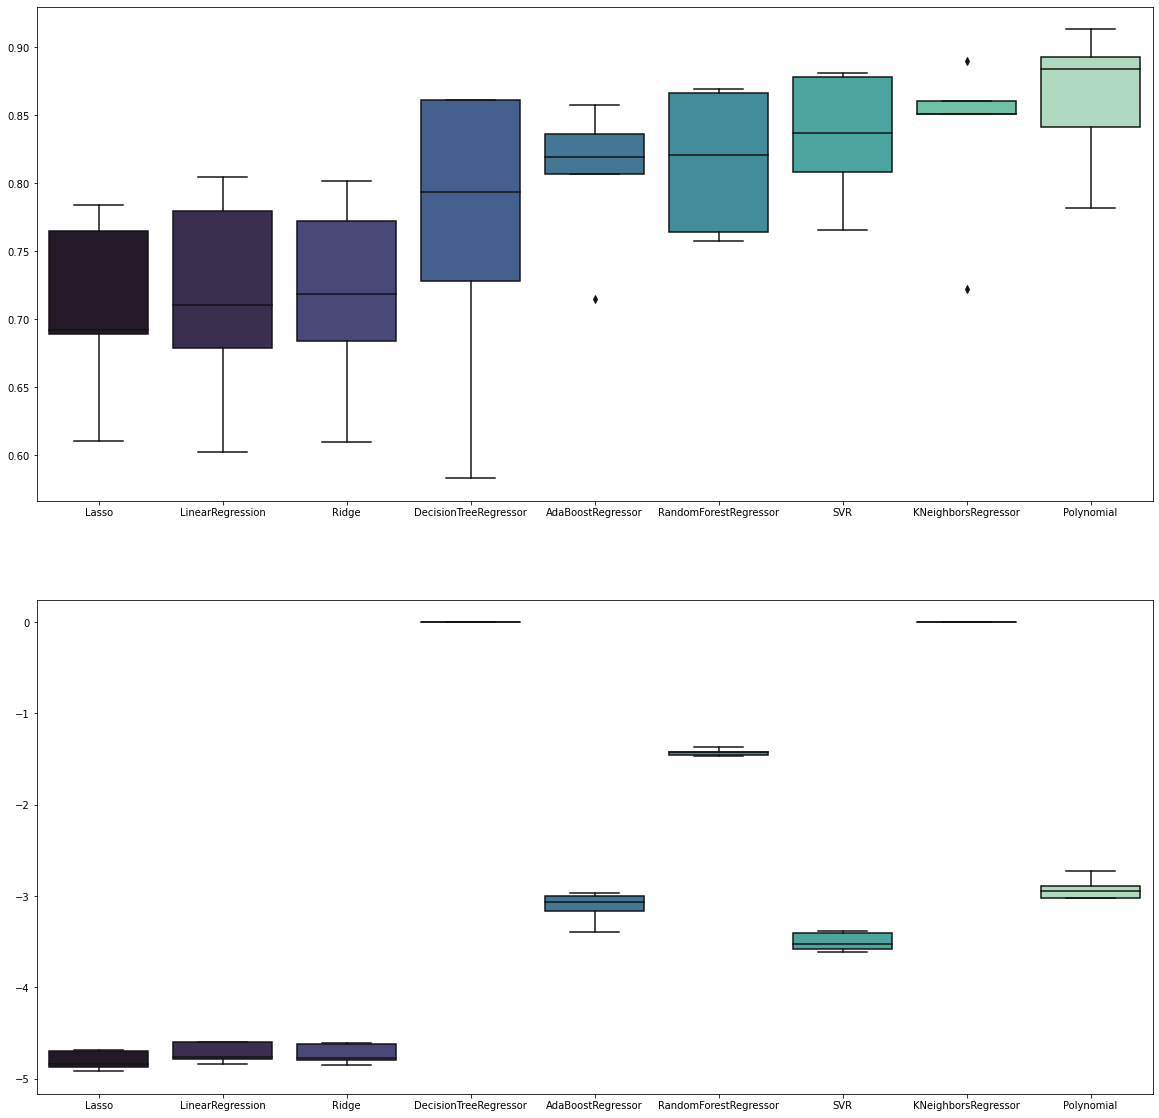

In [38]:
metrics_df.sort_values(by='mean_test_r2', axis=1,inplace=True)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
axs = axs.flatten()
cv_r2 = metrics_df.loc[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2', 'split4_test_r2']]
cv_rmse = metrics_df.loc[['split0_train_neg_root_mean_squared_error','split1_train_neg_root_mean_squared_error','split2_train_neg_root_mean_squared_error','split3_train_neg_root_mean_squared_error', 'split4_train_neg_root_mean_squared_error']]
sns.boxplot(data=cv_r2, ax=axs[0], palette="mako")
sns.boxplot(data=cv_rmse, ax=axs[1], palette="mako")

From the above box plots we can state that the machine learning model giving the best score ($R^2 = 0.86$) is Polynomial Regression and hence it's likely that it will produce the most accurante prediction values of MEDV. 

Other models like KNN ($R^2 = 0.84$) and SVR ($R^2 = 0.83$) also show a comparable score, and in fact KNN is better performing in terms of $RMSE$.

# 4. Testing the best-performing model  <a class="anchor" id="testing"></a>

Now that the best performing model has been trained, we will use it to make predictions of the target variable and evaluate its performance on never-seen-before data (the testing set).  

In [39]:
test_score = search.best_estimator_.score(X_test, y_test)
print("R2: %.3f" % (test_score))

R2: 0.826


This score is not too far from the training score. We can conclude that our model so far, seems to generalize well by adequately capturing the target variable. Below the predicted vs actual MEDV values against each selected feature are shown.

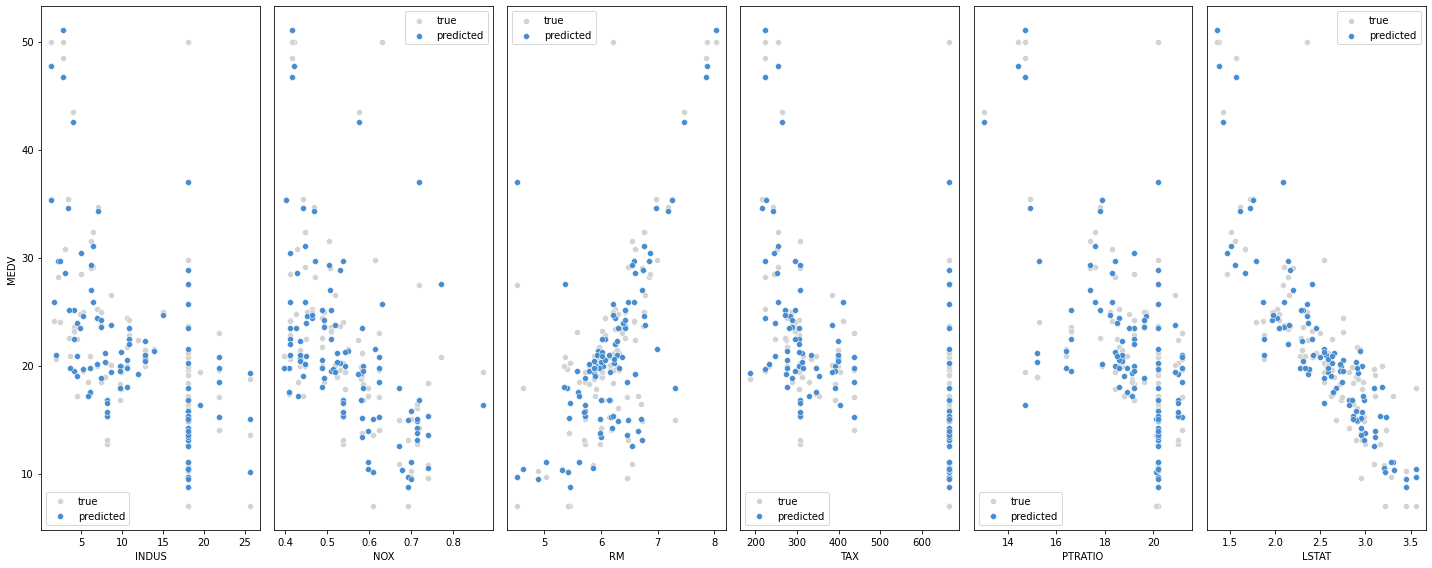

In [40]:
y_predicted = search.best_estimator_.predict(X_test)

features_num = len(selected_names)
fig, axs = plt.subplots(nrows=1, ncols=features_num, figsize=(20, 8))
axs = axs.flatten()

# X_test is still dim 11 which we need to change to 6
X_test_selected = np.array([feature_lst for feature_lst, condition in zip(X_test.T,selected_bool) if condition]).T

for f_num in range(len(selected_names)):
    sns.scatterplot(y=y_test, x=X_test_selected.T[f_num], ax=axs[f_num], color="lightgrey", label="true")
    sns.scatterplot(y=y_predicted, x=X_test_selected.T[f_num], ax=axs[f_num], color="#498DD1", label="predicted")
    if f_num:
        axs[f_num].set_yticks([])
    else:
        axs[f_num].set(ylabel="MEDV")
    axs[f_num].set(xlabel=selected_names[f_num])

plt.tight_layout()
plt.legend()

In [41]:
if 'MEDV' in common_set:
    common_set.remove('MEDV')
common_set

{'INDUS', 'LSTAT', 'NOX', 'PTRATIO', 'RM'}

As we can observe, the common selected features obtained from the 3 feature selection methods in section 2 were all selected during cross-validation using the Pipeline, with just TAX in addition.

# 5. Testing alternative Pipelines <a class="anchor" id="alterntive"></a>

Because an optimal model is not necessarily a robust model we will train the other 2 best performing models, namely, KNN and SVR and compare their performance to the polynomial regression model. 


In [79]:
search_spaces = [
    {'reg': [KNeighborsRegressor()],             # Regression based on k-nearest neighbors
     'reg__n_neighbors': tuple(range(1,10)),
     'reg__leaf_size': tuple(range(1,40)), 
     'reg__p': (1,2),
     'reg__weights': ('uniform', 'distance'),
     'reg__metric': ('minkowski', 'chebyshev')
    }
]

pipe = Pipeline([('fs', SelectKBest(f_regression, k=6)),         # feature selector
                 ('minmax', MinMaxScaler(feature_range=(0, 1))), # scaler
                 ('reg', DummyRegressor())                       # models from which to choose               
                ])

search = GridSearchCV(estimator=pipe, 
                      param_grid=search_spaces,
                      cv=5,
                      scoring=('r2', 'neg_root_mean_squared_error'),  # which metrics to compute
                      return_train_score=True,
                      refit='r2', # criteria to select the best
                      n_jobs=-1
                     )

search.fit(X_train,y_train)
selected_bool = search.best_estimator_.named_steps['fs'].get_support()
selected_names = [feature for feature, condition in zip(boston_scaled.columns[:-1],selected_bool) if condition]
print("Selected features:", selected_names)
print("Best estimator:", search.best_estimator_.named_steps['reg'])
print("R2 Training: %.3f" %search.best_score_) 
test_score = search.best_estimator_.score(X_test, y_test)
print("R2 Testing: %.3f" % (test_score))

Selected features: ['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
Best estimator: KNeighborsRegressor(leaf_size=1, n_neighbors=3, p=1, weights='distance')
R2 Training: 0.835
R2 Testing: 0.832


In [49]:
search_spaces = [
    {'reg': [SVR()],                             # Support Vector Regression
     'reg__kernel': ('linear', 'poly', 'rbf'),
     'reg__degree':  (2,3),
     'reg__gamma': np.logspace(-2, 2, 5),
     'reg__C': [1,2,3]
    }
]

# Instiate pipeline
pipe = Pipeline([('fs', SelectKBest(f_regression, k=6)),         # feature selector
                 ('minmax', MinMaxScaler(feature_range=(0, 1))), # scaler
                 ('reg', DummyRegressor())                       # models from which to choose               
                ])

search = GridSearchCV(estimator=pipe, 
                      param_grid=search_spaces,
                      cv=5,
                      scoring=('r2', 'neg_root_mean_squared_error'),  # which metrics to compute
                      return_train_score=True,
                      refit='r2', # criteria to select the best
                      n_jobs=-1
                     )

search.fit(X_train,y_train)
selected_bool = search.best_estimator_.named_steps['fs'].get_support()
selected_names = [feature for feature, condition in zip(boston_scaled.columns[:-1],selected_bool) if condition]
print("Selected features:", selected_names)
print("Best estimator:", search.best_estimator_.named_steps['reg'])
print("R2 Training: %.2f" %search.best_score_) 
test_score = search.best_estimator_.score(X_test, y_test)
print("R2 Testing: %.3f" % (test_score))

Selected features: ['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
Best estimator: SVR(C=2, degree=2, gamma=10.0, kernel='poly')
R2 Training: 0.83
R2 Testing: 0.807


From this results it seems that KNN is able to generalize slightly better to unseen data. And it is likely that this is tied to the smaller variability and optimal RMSE results, as seen in the blox plots of section 3.

Finally we will perform two additional experiments before drawing final conclusions on performance. First the `MinMaxScaler` scaler will be substituted to `StandardScaler` and then we will consider for `SelectKBest` a variable number of features from 1 to 11, instead of just 6.

In [80]:
# using StandardScaler
search_spaces = [
    {'reg': [make_pipeline(PolynomialFeatures(), Ridge(random_state=42))],
     'reg__polynomialfeatures__degree': (2,3,4),
     'reg__ridge__alpha': np.arange(0.1,2,0.1)
    },
    {'reg': [KNeighborsRegressor()],             # Regression based on k-nearest neighbors
     'reg__n_neighbors': tuple(range(1,10)),
     'reg__leaf_size': tuple(range(1,40)), 
     'reg__p': (1,2),
     'reg__weights': ('uniform', 'distance'),
     'reg__metric': ('minkowski', 'chebyshev')
    }
]

# Instiate pipeline
pipe = Pipeline([('fs', SelectKBest(f_regression, k=6)),         # feature selector
                 ('minmax', StandardScaler()), # scaler
                 ('reg', DummyRegressor())                       # models from which to choose               
                ])

search = GridSearchCV(estimator=pipe, 
                      param_grid=search_spaces,
                      cv=5,
                      scoring=('r2', 'neg_root_mean_squared_error'),  # which metrics to compute
                      return_train_score=True,
                      refit='r2', # criteria to select the best
                      n_jobs=-1
                     )

search.fit(X_train,y_train)
selected_bool = search.best_estimator_.named_steps['fs'].get_support()
selected_names = [feature for feature, condition in zip(boston_scaled.columns[:-1],selected_bool) if condition]
print("Selected features:", selected_names)
print("Best estimator:", search.best_estimator_.named_steps['reg'])
print("R2 Training: %.3f" %search.best_score_) 
test_score = search.best_estimator_.score(X_test, y_test)
print("R2 Testing: %.3f" % (test_score))

Selected features: ['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
Best estimator: Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=1.9000000000000001, random_state=42))])
R2 Training: 0.849
R2 Testing: 0.799


In [83]:
# inspecting best number of parameters
search_spaces = [        
    {'reg': [make_pipeline(PolynomialFeatures(), Ridge(random_state=42))],
     'reg__polynomialfeatures__degree': (2,3,4),
     'reg__ridge__alpha': np.arange(0.1,2,0.1)},
    { 'fs': [SelectKBest(f_regression)],
      'fs__k': range(1,12)
    }
    
]

# Instiate pipeline
pipe = Pipeline([('fs', SelectKBest(f_regression)),         # feature selector
                 ('minmax', StandardScaler()), # scaler
                 ('reg', DummyRegressor())                       # models from which to choose               
                ])

search = GridSearchCV(estimator=pipe, 
                      param_grid=search_spaces,
                      cv=5,
                      scoring=('r2', 'neg_root_mean_squared_error'),  # which metrics to compute
                      return_train_score=True,
                      refit='r2', # criteria to select the best
                      n_jobs=-1
                     )

search.fit(X_train,y_train)
selected_bool = search.best_estimator_.named_steps['fs'].get_support()
selected_names = [feature for feature, condition in zip(boston_scaled.columns[:-1],selected_bool) if condition]
print("Selected features:", selected_names)
print("Best estimator:", search.best_estimator_.named_steps['reg'])
print("R2 Training: %.3f" %search.best_score_) 
test_score = search.best_estimator_.score(X_test, y_test)
print("R2 Testing: %.3f" % (test_score))

Selected features: ['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT']
Best estimator: Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=1.9000000000000001, random_state=42))])
R2 Training: 0.877
R2 Testing: 0.805


In [82]:
search_spaces = [        
    {'reg': [make_pipeline(PolynomialFeatures(), Ridge(random_state=42))],
     'reg__polynomialfeatures__degree': (2,3,4),
     'reg__ridge__alpha': np.arange(0.1,2,0.1),
     'fs': [SelectKBest(f_regression)],
     'fs__k': np.arange(1,4)
    }
]

# Instiate pipeline
pipe = Pipeline([('fs', SelectKBest(f_regression)),         # feature selector
                 ('minmax', StandardScaler()), # scaler
                 ('reg', DummyRegressor())                       # models from which to choose               
                ])

search = GridSearchCV(estimator=pipe, 
                      param_grid=search_spaces,
                      cv=5,
                      scoring=('r2', 'neg_root_mean_squared_error'),  # which metrics to compute
                      return_train_score=True,
                      refit='r2', # criteria to select the best
                      n_jobs=-1
                     )

search.fit(X_train,y_train)
selected_bool = search.best_estimator_.named_steps['fs'].get_support()
selected_names = [feature for feature, condition in zip(boston_scaled.columns[:-1],selected_bool) if condition]
print("Selected features:", selected_names)
print("Best estimator:", search.best_estimator_.named_steps['reg'])
print("R2 Training: %.3f" %search.best_score_) 
test_score = search.best_estimator_.score(X_test, y_test)
print("R2 Testing: %.3f" % (test_score))

Selected features: ['RM', 'PTRATIO', 'LSTAT']
Best estimator: Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=1.9000000000000001, random_state=42))])
R2 Training: 0.771
R2 Testing: 0.768


# 6. Conclusions  <a class="anchor" id="conclusions"></a>

The aim was to determine the attributes that best explained variation in house pricing and to construct the best-performing model able to represent the patterns and trends in the dataset. Various statistical techniques were used to treat extraneous observations and eliminate non-relevant predictors.

Attribute RM (average number of rooms), PTRATIO (ratio of students to teachers in schools) and LSAT (percentage of “lower class” homeowners) are alone capable of predicting MEDV to a good accuracy. Training and testing scores in this case are almost equivalent, hinting good generalization.  

Both Polynomial Regression and KNN are good models for this particular dataset and using `MinMaxScaler` as oposed to `StandardScaler` gives slightly better results. 

One drawback is that a portion (20%) of the same dataset was used to make predictions. As demographics, interest rates, pollution levels and economic and political environment change, the real-state market evolves. It would therefore be a good experiment to use this model as a forecasting tool and assess whether it is still applicable almost 4 decades later, and if not, which other predictors should be considered.  